In [3]:
import pandas as pd
import glob

files = [i for i in glob.glob(r'/workspaces/miniconda/PKdata/data/*.csv') if 'nca' not in i]

In [12]:

for f_idx, f in enumerate(files):
    if f_idx == 0:
        df_out = pd.read_csv(f)
        df_out = df_out[[i for i in df_out.columns if 'unnamed' not in i.lower()]]
        df_out['TIME'] = df_out['TIME'].astype(float)
    else:
        tmp = pd.read_csv(f)
        tmp = tmp[[i for i in tmp.columns if 'unnamed' not in i.lower()]]
        if 'TIME' in tmp.columns:
            tmp['TIME'] = df_out['TIME'].astype(float)
            merge_c = ['ID', 'TIME']
        else:
            merge_c = ['ID']
        df_out = df_out.merge(tmp, how = 'left', on = merge_c)
        

In [44]:
import numpy as np
from utils import safe_signed_log
xth_df = df_out.loc[df_out['ANALYTE'] == 'xanthohumol', :].copy()
xth_df['CONC_ln'] = safe_signed_log(xth_df['CONC'])

In [70]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

def find_terminal_phase(df, min_points=4):
    """
    Finds the start of the terminal elimination phase in PK data using
    rolling window linear regressions and adjusted R-squared.

    Args:
        time (array-like): Time points.
        concentration (array-like): Corresponding drug concentrations.
        min_points (int): Minimum number of points required for a regression.

    Returns:
        tuple: (best_start_index, best_slope, best_intercept, best_adj_r2, results_df)
               - best_start_index: Index in the time/concentration arrays
                 corresponding to the start of the best-fit terminal phase.
               - best_slope: Slope of the best-fit line (negative of k_elim).
               - best_intercept: Intercept of the best-fit line.
               - best_adj_r2: Adjusted R-squared of the best-fit line.
               - results_df: DataFrame containing the results of all regressions.
               Returns (None, None, None, None, None) if no suitable terminal
               phase is found.
    """
    times = df['TIME'].unique()
    

    results = []
    for start_index in range(len(times) - min_points + 1):
        for end_index in range(start_index + min_points, len(times) + 1): # Iterate through end indices
            
            eval_times = times[start_index:end_index]
            #current_ln_conc = ln_concentration[start_index:end_index]
            x = df.loc[df['TIME'].isin(eval_times), 'TIME']
            y = df.loc[df['TIME'].isin(eval_times), 'CONC_ln']

            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = linregress(x, y)

            # Calculate adjusted R-squared
            n = len(eval_times)
            k = 1  # Number of predictors (time)
            adj_r2 = 1 - (1 - r_value**2) * (n - 1) / (n - k - 1)

            results.append({
                'ID':df['ID'].unique()[0],
                'start_index': start_index,
                'end_index': end_index,
                'start_time': eval_times[0],
                'end_time': eval_times[-1],
                'slope': slope,
                'intercept': intercept,
                'r_value': r_value,
                'adj_r2': adj_r2,
                'n_points': n
            })

    results_df = pd.DataFrame(results)

    # Find the regression with the highest adjusted R-squared
    if not results_df.empty:
        best_row = results_df.loc[results_df['adj_r2'].idxmax()]
        best_start_index = int(best_row['start_index'])  # Ensure it's an integer
        best_slope = best_row['slope']
        best_intercept = best_row['intercept']
        best_adj_r2 = best_row['adj_r2']

        return results_df
    else:
         return None


In [83]:
times = xth_df['TIME'].unique()

In [101]:
times

array([  0.  ,   0.25,   0.5 ,   1.  ,   1.5 ,   2.  ,   4.  ,   8.  ,
        12.  ,  24.  ,  48.  ,  72.  ,  96.  , 120.  ])

In [98]:
def estimate_subject_slope_cv(df):
    results = []
    for start_idx, starttime in enumerate(times):
        start_idx_slopes = []
        if (start_idx + 1) < len(times):
            for end_idx, endtime in enumerate(times[start_idx+1:]):
                f = (df['TIME'] >= starttime) & (df['TIME'] <= endtime)
                work_df = df.loc[f, :]
                x = work_df['TIME'].values
                y = work_df['CONC_ln'].values
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                
                n = len(work_df['TIME'].unique())
                k = 1  # Number of predictors (time)
                if n > 2:
                    adj_r2 = 1 - (1 - r_value**2) * (n - 1) / (n - k - 1)
                else:
                    adj_r2 = None
                start_idx_slopes.append(slope)
                if len(start_idx_slopes) > 1:
                    slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
                else:
                    slope_cv = None
                results.append({
                    'ID':work_df['ID'].unique()[0],
                    'start_index': start_idx,
                    'end_index': end_idx,
                    'start_time': starttime,
                    'end_time': endtime,
                    'slope': slope,
                    'start_idx_slope_cv':slope_cv,
                    'intercept': intercept,
                    'r_value': r_value,
                    'adj_r2': adj_r2,
                    'n_points': n
                })
    return pd.DataFrame(results)
    

In [103]:
xth_df.loc[xth_df['ID'] == 'M1', :]

,ID,TIME,CONC,ANALYTE,DOSE,ROUTE,Sex,CONC_ln
504,M1,0.00,0,xanthohumol,NaN,NaN,M,0.000000
505,M1,0.25,35,xanthohumol,NaN,NaN,M,3.555348
506,M1,0.50,49,xanthohumol,NaN,NaN,M,3.891820
507,M1,1.00,33,xanthohumol,NaN,NaN,M,3.496508
508,M1,1.50,14,xanthohumol,60.0,oral,M,2.639057
509,M1,2.00,13,xanthohumol,NaN,NaN,M,2.564949
510,M1,4.00,8,xanthohumol,NaN,NaN,M,2.079442
511,M1,8.00,10,xanthohumol,NaN,NaN,M,2.302585
512,M1,12.00,6,xanthohumol,NaN,NaN,M,1.791759
513,M1,24.00,4,xanthohumol,NaN,NaN,M,1.386294


In [121]:
dfs = []
for sub in xth_df['ID'].unique():
    look = estimate_subject_slope_cv(xth_df.loc[xth_df['ID'] == sub, :])
    look['abs_cv'] = np.abs(look['start_idx_slope_cv'])
    look['cv_sign'] = np.sign(look['start_idx_slope_cv'])
    signs = look.groupby('start_time')['cv_sign'].mean().reset_index().rename(columns = {'cv_sign':'start_time_mean_cv_sign'})
    start_idx_cv_mean = look.groupby('start_time')['abs_cv'].mean().reset_index().rename(columns = {'cv_sign':'start_time_mean_abs_cv'})
    start_idx_cv_std = look.groupby('start_time')['abs_cv'].std().reset_index().rename(columns = {'cv_sign':'start_time_std_mean_cv'})
    look = (look
            .merge(signs, how = 'left', on = 'start_time')
            .merge(start_idx_cv_mean, how = 'left', on = 'start_time')
            .merge(start_idx_cv_std, how = 'left', on = 'start_time')
            )
    dfs.append(look.copy())
    

/tmp/ipykernel_56508/1178704772.py:21: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/tmp/ipykernel_56508/1178704772.py:21: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/tmp/ipykernel_56508/1178704772.py:21: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/tmp/ipykernel_56508/1178704772.py:21: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/tmp/ipykernel_56508/1178704772.py:21: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/tmp/ipykernel_56508/1178704772.py:21: RuntimeWarning: invalid value encountered in scalar divide
  slope_cv = np.std(start_idx_slopes) / np.mean(start_idx_slopes)
/tmp/ipykernel_5

In [ ]:
tmp = dfs[0]
tmp.loc[tmp['cv_sign'] == -1 , :]
#try regresssing delta t vs cv at that delta t

,ID,start_index,end_index,start_time,end_time,slope,start_idx_slope_cv,intercept,r_value,adj_r2,n_points,abs_cv_x,cv_sign,start_time_mean_cv_sign,abs_cv_y,abs_cv
37,L1,3,1,1.0,2.0,-1.734601,-0.029064,5.277292,-0.999469,0.997875,3,0.029064,-1.0,-1.0,0.697439,0.425192
38,L1,3,2,1.0,4.0,-1.134199,-0.175121,4.416715,-0.985267,0.956126,4,0.175121,-1.0,-1.0,0.697439,0.425192
39,L1,3,3,1.0,8.0,-0.466903,-0.404387,3.146013,-0.841597,0.611047,5,0.404387,-1.0,-1.0,0.697439,0.425192
40,L1,3,4,1.0,12.0,-0.159415,-0.608505,2.363157,-0.491273,0.051686,6,0.608505,-1.0,-1.0,0.697439,0.425192
41,L1,3,5,1.0,24.0,-0.101044,-0.763990,2.134348,-0.585725,0.211688,7,0.763990,-1.0,-1.0,0.697439,0.425192
42,L1,3,6,1.0,48.0,-0.048986,-0.902284,1.819843,-0.563649,0.203984,8,0.902284,-1.0,-1.0,0.697439,0.425192
43,L1,3,7,1.0,72.0,-0.030907,-1.024448,1.663016,-0.558969,0.214224,9,1.024448,-1.0,-1.0,0.697439,0.425192
44,L1,3,8,1.0,96.0,-0.022154,-1.134339,1.558395,-0.557211,0.224295,10,1.134339,-1.0,-1.0,0.697439,0.425192
45,L1,3,9,1.0,120.0,-0.017033,-1.234812,1.477528,-0.555054,0.231205,11,1.234812,-1.0,-1.0,0.697439,0.425192
47,L1,4,1,1.5,4.0,-1.029694,-0.280507,4.074172,-0.988928,0.955956,3,0.280507,-1.0,-1.0,1.009632,0.440277


In [117]:
look

,ID,start_index,end_index,start_time,end_time,slope,start_idx_slope_cv,intercept,r_value,adj_r2,n_points,abs_cv,cv_sign
0,M1,0,0,0.0,0.25,14.221392,NaN,0.000000,1.000000,NaN,2,NaN,NaN
1,M1,0,1,0.0,0.50,7.783641,0.292558,0.536479,0.902395,0.628632,3,0.292558,1.0
2,M1,0,2,0.0,1.00,2.822211,0.563899,1.501202,0.657643,0.148742,4,0.563899,1.0
3,M1,0,3,0.0,1.50,1.007630,0.793088,2.061587,0.382191,-0.138574,5,0.793088,1.0
4,M1,0,4,0.0,2.00,0.434701,0.985278,2.310917,0.235700,-0.180557,6,0.985278,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,M1,10,1,48.0,96.00,-0.022888,-0.333333,2.014123,-0.866025,0.500000,3,0.333333,-1.0
87,M1,10,2,48.0,120.00,-0.013733,-0.490653,1.428196,-0.774597,0.400000,4,0.490653,-1.0
88,M1,11,0,72.0,96.00,0.000000,NaN,0.000000,0.000000,NaN,2,NaN,NaN
89,M1,11,1,72.0,120.00,0.000000,NaN,0.000000,0.000000,-1.000000,3,NaN,NaN


In [114]:
signs = look.groupby('start_time')['cv_sign'].mean()
start_idx_cv_mean = look.groupby('start_time')['abs_cv'].mean()
start_idx_cv_std = look.groupby('start_time')['abs_cv'].std()

In [119]:
start_idx_cv_std / start_idx_cv_mean

start_time
0.00     0.431303
0.25     0.432217
0.50     0.522009
1.00     0.410865
1.50     0.335802
2.00     0.132481
4.00     0.525206
8.00     0.218880
12.00    0.125904
24.00    0.141450
48.00    0.270009
72.00         NaN
96.00         NaN
Name: abs_cv, dtype: float64

<Axes: xlabel='TIME', ylabel='CONC_ln'>

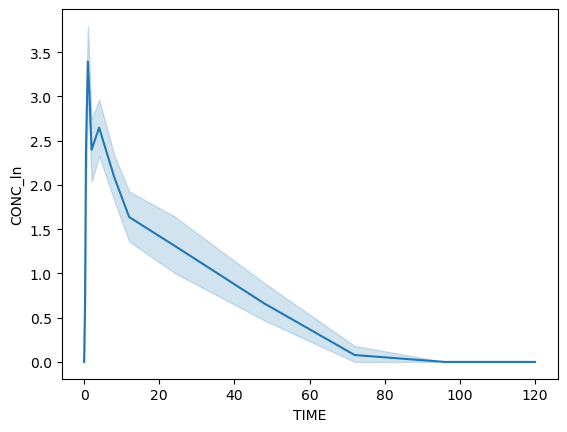

In [45]:
import seaborn as sns


sns.lineplot(xth_df, x = 'TIME', y = 'CONC_ln',)

In [25]:
from sklearn.metrics import auc

In [28]:
xth_df['ConcTime'] = xth_df['CONC'] * xth_df['TIME']

In [38]:
auc_df = (xth_df
 .groupby('ID')[['TIME', 'CONC']]
 .apply(lambda x: auc(x['TIME'], x['CONC']))
 .reset_index()
 .rename(columns = {0:'AUC'})
 )

auc_df.head()


,ID,AUC
0,H1,941.875
1,H10,820.875
2,H11,1038.500
3,H12,899.125
4,H13,425.000


In [39]:
#per subject, calculate AUC and AUMC
res = []
for sub in xth_df['ID'].unique():
    work_df = xth_df.loc[xth_df['ID'] == sub, :]
    auc_out = auc(work_df['TIME'].values, work_df['CONC'].values)
    auc_mc = auc(work_df['TIME'].values, work_df['ConcTime'].values)
    res.append({
        'ID':sub, 'AUC':auc_out, 'AUCMC':auc_mc
    })
res = pd.DataFrame(res)

In [42]:
#per subject calculate MRT
res['MRT'] = res['AUCMC']/res['AUC']
res

,ID,AUC,AUCMC,MRT
0,L1,72.000,523.2500,7.267361
1,L2,326.375,6615.4375,20.269437
2,L3,84.125,545.8125,6.488113
3,L4,12.500,13.5000,1.080000
4,L5,185.750,1064.6250,5.731494
5,L6,190.500,686.5000,3.603675
6,L7,143.375,471.1875,3.286399
7,L8,200.875,889.5625,4.428438
8,L9,134.625,1428.1875,10.608635
9,L10,25.875,58.6875,2.268116
